<a href="https://colab.research.google.com/github/SoukainaElidrissi/Atelier1/blob/main/Atelier1Ex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from tqdm import tqdm
from torch.nn import Dropout
from numpy import argmax
from numpy import vstack
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, recall_score

In [8]:
# #
# Load the dataset
df = pd.read_csv('/content/sample_data/predictive_maintenance.csv')

# Select only numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Replace NaN values with the mean of the respective columns (numeric only)
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Encode categorical variables ('Product ID' and 'Type') using one-hot encoding
df = pd.get_dummies(df, columns=['Product ID', 'Type'])

# Label encode the 'Failure Type' column
label_encoder = LabelEncoder()
df['Failure Type'] = label_encoder.fit_transform(df['Failure Type'])

# Normalize numerical features to a specific range (e.g., 0 to 1)
numeric_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
scaler = MinMaxScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])
#Display the preprocessed DataFrame
#print(df)

In [3]:
# Dataset definition
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, dataframe):
        # store the inputs and outputs
        self.X = dataframe.drop(['Target', 'Failure Type'], axis=1).values.astype('float32')
        self.y = dataframe['Failure Type'].values.astype('int64')  # Assuming Failure Type is integer-encoded
#         self.y = LabelEncoder().fit_transform(self.y)

    # number of rows in the dataset
    def __len__(self):
        return len(self.X)

    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

    # get indexes for train and test rows
    def get_splits(self, test_size=0.33):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=test_size, random_state=42)
        train = CSVDataset(pd.DataFrame(data=X_train, columns=df.columns[:-2], dtype='float32'))
        test = CSVDataset(pd.DataFrame(data=X_test, columns=df.columns[:-2], dtype='float32'))
        return train, test

In [4]:
print(df.describe())

               UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000             0.511405                 0.531551   
std     2886.89568             0.217419                 0.183177   
min        1.00000             0.000000                 0.000000   
25%     2500.75000             0.326087                 0.382716   
50%     5000.50000             0.521739                 0.543210   
75%     7500.25000             0.673913                 0.666667   
max    10000.00000             1.000000                 1.000000   

       Rotational speed [rpm]   Torque [Nm]  Tool wear [min]        Target  \
count            10000.000000  10000.000000     10000.000000  10000.000000   
mean                 0.215818      0.497073         0.426684      0.033900   
std                  0.104356      0.136936         0.251597      0.180981   
min                  0.000000      0.000000         0.000000      0.000000 

In [ ]:
correlation_matrix = df[numeric_features].corr()

# Heatmap de la matrice de corrélation

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

# Diagrammes de dispersion pour quelques paires de variables
sns.pairplot(df[numeric_features])
#plt.show()

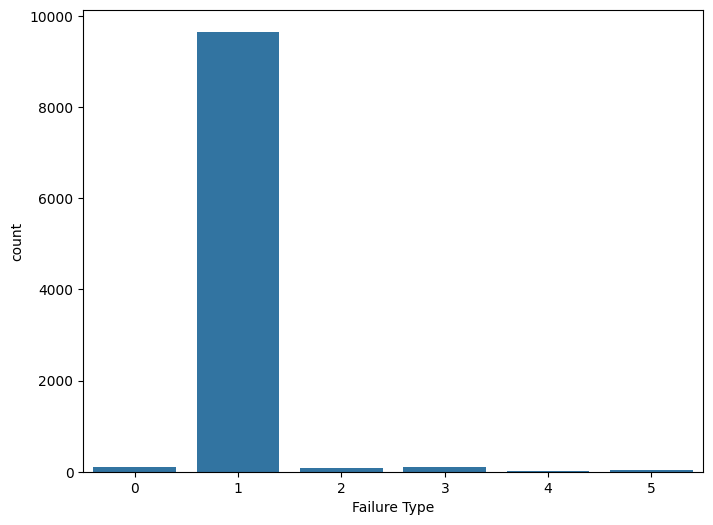

In [5]:
# Diagramme à barres pour la variable cible
plt.figure(figsize=(8, 6))
sns.countplot(x='Failure Type', data=df)
plt.show()

In [ ]:
# DNN
# model
class MLP(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, 10)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.dropout1 = Dropout(0.2)
        # second hidden layer
        self.hidden2 = Linear(10, 8)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # third hidden layer and output
        self.hidden3 = Linear(8, 3)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Softmax(dim=1)

    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.dropout1(X)
        # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # output layer
        X = self.hidden3(X)
        X = self.act3(X)
        return X

In [6]:
# prepare the dataset
def prepare_data(df):


    # Instantiate the dataset
    dataset = CSVDataset(df)

    # Split the dataset into train and test
    train, test = dataset.get_splits()

    # Create DataLoader for training and testing
    train_loader = DataLoader(train, batch_size=512, shuffle=True)
    test_loader = DataLoader(test, batch_size=512, shuffle=False)
    return train_loader, test_loader

In [ ]:
number_epochs = 100
learning_rate = 0.1
loss_per_epoch = []
loss_per_epoch_validation= []

# #####
# accuracy_per_epoch = []
# accuracy_per_epoch_validation = []
# #####
# train the model
def train_model(train_loader, model):
    size = len(train_loader.dataset)
    # define loss function MSE
    criterion = CrossEntropyLoss()
    # define the optimization ADAM
    # regularization L2 = weight_decay #
    optimizer =  Adam(model.parameters(), lr=learning_rate, weight_decay= 0.1 )
    epoch = 0

    # enumerate epochs
    #while(average_loss >= desired_error): # accroding to loss function do epochs
    for epoch in tqdm(range(number_epochs),desc='Training Epochs'):
        print(f"Epoch {epoch+1}\n-------------------------------") # enumerate mini batches
        # training data
        total_loss = 0.0
        model.train()
        TrainigStep_loss = []
        for batch, (inputs, targets) in enumerate(train_loader):

            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            #print("y befor" , inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
            TrainigStep_loss.append(loss.item())
            #total_loss += loss.item()

        #average_loss = total_loss / len(train_loader)
        loss = np.array(TrainigStep_loss).mean()
        loss_per_epoch.append(loss)
        print(f"loss: {loss:>7f}")
        #print(f"Average loss :{average_loss:>7f}" )

        # test / validation data
        model.eval()     # Optional when not using Model Specific layer
        validationStep_loss = []
        for batch, (inputs, targets) in enumerate(test_loader):

            # Forward Pass
            outputs = model(inputs)
            # Find the Loss
            validation_loss = criterion(outputs, targets)
            # Calculate Loss
            validationStep_loss.append(validation_loss.item())

        loss_per_epoch_validation.append(np.array(validationStep_loss).mean())

        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = np.average(TrainigStep_loss)
        valid_loss = np.average(validationStep_loss)
                # Inside the training loop
#         # ...
#         train_accuracy = evaluate_model(train_loader, model)
#         validation_accuracy = evaluate_model(test_loader, model)
#         accuracy_per_epoch.append(train_accuracy)
#         accuracy_per_epoch_validation.append(validation_accuracy)
#         # ...






In [ ]:
# evaluate the model
def evaluate_model(test_loader, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_loader):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        # convert to class labels
        yhat = argmax(yhat, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
#     predictions, actuals = vstack(predictions), vstack(actuals)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    f1 = f1_score(actuals, predictions, average='weighted')
    sensitivity = recall_score(actuals, predictions, average='weighted')
    return acc, f1, sensitivity
# , f1

In [ ]:
# prepare the data
train_loader, test_loader = prepare_data(df)
print(len(train_loader.dataset), len(test_loader.dataset))
# # define the network
# model = MLP(5)
# Modifier le modèle en fonction du nombre de caractéristiques dans votre ensemble de données
num_features = len(train_loader.dataset[0][0])
model = MLP(num_features)

# train the model
train_model(train_loader, model)

In [ ]:
import plotly.graph_objects as go

# Assuming you have loss_per_epoch and loss_per_epoch_validation lists
#loss_per_epoch = [0.5, 0.4, 0.3]  # Replace with your actual list
#loss_per_epoch_validation = [0.6, 0.5, 0.4]  # Replace with your actual list

# Create the figure
fig = go.Figure()

# Add training loss trace
fig.add_trace(go.Scatter(x=list(range(len(loss_per_epoch))),
                         y=loss_per_epoch,
                         mode='lines',
                         name='train'))

# Add validation loss trace
fig.add_trace(go.Scatter(x=list(range(len(loss_per_epoch_validation))),
                         y=loss_per_epoch_validation,
                         mode='lines',
                         name='test'))

# Add labels and title
fig.update_layout(title='model loss',
                  xaxis=dict(title='epoch'),
                  yaxis=dict(title='loss'))

# Show the figure
fig.show()
#fig.write_image("LOSS_DNN_(30,20,10,1).svg")

In [ ]:
# evaluate the model on the test set
acc_test, f1_test, sensitivity_test = evaluate_model(test_loader, model)
print(f'Test Accuracy: {acc_test:.3f}, Test F1 Score: {f1_test:.3f}, Test Sensitivity: {sensitivity_test:.3f}')

# evaluate the model on the training set
acc_train, f1_train, sensitivity_train = evaluate_model(train_loader, model)
print(f'Training Accuracy: {acc_train:.3f}, Training F1 Score: {f1_train:.3f}, Training Sensitivity: {sensitivity_train:.3f}')

In [ ]:
# make a class prediction for one row of data
def predict(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return yhat